### Thesis notebook 4.1. - NOVA IMS

### Data understanding, feature selection and modeling - Non-temporal data

In [1]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time
import plotly.express as px

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

from lightgbm import LGBMModel,LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer,PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering , KMeans, DBSCAN

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.datasets import make_classification, load_digits
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#imports dataframes

course_programs = pd.read_excel("../Data/Modeling Stage/Nova_IMS_Non_temporal_Datasets.xlsx", 
                                dtype = {
                                    'course_encoding' : object,
                                    'cd_curso' :  object,
                                    'courseid' : object,
                                    'userid' : object},
                               sheet_name = None)

#drop unnamed 0 column
for i in course_programs:
    course_programs[i].drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
course_programs['Date_threshold_100']

,course_encoding,cd_curso,semestre,courseid,userid,Number of clicks,Number of sessions,Largest period of inactivity,Total time online,Average session duration,Clicks on Course,Resources viewed,Discussions viewed,Quizzes started,Assignments submitted,Assignments viewed,Forum posts,exam_mark,final_mark,Average grade of assignments
0,0,4281,S1,200101,417,234,58,22.610417,0.197222,0.003400,122,26,3,0,0,0,0,12.0,12,NaN
1,0,4281,S1,200101,1042,279,71,9.052083,0.426389,0.006005,147,33,6,0,0,0,0,15.0,15,NaN
2,0,4281,S1,200101,1100,243,53,16.038889,0.179167,0.003381,109,25,16,0,0,0,0,16.0,16,NaN
3,0,4281,S1,200101,2674,200,32,15.750000,0.180556,0.005642,95,27,6,0,0,0,0,16.0,16,NaN
4,0,4281,S1,200101,3802,243,46,15.250000,0.270139,0.005873,115,36,0,0,0,0,0,16.0,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,91,9434,T4,200194,6608,3,1,0.000694,0.001389,0.001389,2,1,0,0,0,0,0,0.0,0,NaN
8282,91,9434,T4,200194,6610,356,37,7.000694,0.270139,0.007301,101,19,1,5,0,0,0,17.0,17,9.660
8283,91,9434,T4,200194,6611,426,38,7.797917,0.379861,0.009996,102,18,1,8,0,0,0,16.0,16,9.240
8284,91,9434,T4,200194,6655,176,17,13.260417,0.184722,0.010866,37,10,0,3,0,0,0,14.0,14,8.720


##  Stage: Data understanding Stage

#### INITIAL EXPLORATION, CLEANING & FEATURE ENGINEERING

In [5]:
#Step1 - Take a look at the datesets
for i in course_programs:
    print(f'Time period: {i}\n\n{course_programs[i].head()}\n')

Time period: Date_threshold_10

  course_encoding cd_curso semestre courseid userid  Number of clicks  \
0               0     4281       S1   200101    417              71.0   
1               0     4281       S1   200101   1042              33.0   
2               0     4281       S1   200101   1100              37.0   
3               0     4281       S1   200101   2674              14.0   
4               0     4281       S1   200101   3802              36.0   

   Number of sessions  Largest period of inactivity  Total time online  \
0                16.0                       10052.0              100.0   
1                16.0                        4377.0               12.0   
2                11.0                        6959.0               25.0   
3                 2.0                        3599.0               21.0   
4                 8.0                        9581.0               30.0   

   Average session duration  Clicks on Course  Resources viewed  \
0                

In [6]:
#Step1 - Take a look at the datesets
for i in course_programs:
    print(f'Time period: {i}\n\n{course_programs[i].info()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   course_encoding               8286 non-null   object 
 1   cd_curso                      8286 non-null   object 
 2   semestre                      8286 non-null   object 
 3   courseid                      8286 non-null   object 
 4   userid                        8286 non-null   object 
 5   Number of clicks              7410 non-null   float64
 6   Number of sessions            7410 non-null   float64
 7   Largest period of inactivity  7410 non-null   float64
 8   Total time online             7410 non-null   float64
 9   Average session duration      7410 non-null   float64
 10  Clicks on Course              7410 non-null   float64
 11  Resources viewed              7410 non-null   float64
 12  Discussions viewed            7410 non-null   float64
 13  Qui

In [7]:
#describe method
for i in tqdm(course_programs):
    print(f'Time period: {i}\n\n{course_programs[i].describe(include = "all")}\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Time period: Date_threshold_10

        course_encoding  cd_curso semestre  courseid  userid  \
count            8286.0    8286.0     8286    8286.0  8286.0   
unique             92.0       6.0        6      83.0  1231.0   
top                69.0    9434.0       S1  200167.0  3178.0   
freq              178.0    2671.0     3360     248.0    14.0   
mean                NaN       NaN      NaN       NaN     NaN   
std                 NaN       NaN      NaN       NaN     NaN   
min                 NaN       NaN      NaN       NaN     NaN   
25%                 NaN       NaN      NaN       NaN     NaN   
50%                 NaN       NaN      NaN       NaN     NaN   
75%                 NaN       NaN      NaN       NaN     NaN   
max                 NaN       NaN      NaN       NaN     NaN   

        Number of clicks  Number of sessions  Largest period of inactivity  \
count        7410.000000         7410.000000                   7410.000000   
unique               NaN                 Na

Time period: Date_threshold_33

        course_encoding  cd_curso semestre  courseid  userid  \
count            8286.0    8286.0     8286    8286.0  8286.0   
unique             92.0       6.0        6      83.0  1231.0   
top                69.0    9434.0       S1  200167.0  3178.0   
freq              178.0    2671.0     3360     248.0    14.0   
mean                NaN       NaN      NaN       NaN     NaN   
std                 NaN       NaN      NaN       NaN     NaN   
min                 NaN       NaN      NaN       NaN     NaN   
25%                 NaN       NaN      NaN       NaN     NaN   
50%                 NaN       NaN      NaN       NaN     NaN   
75%                 NaN       NaN      NaN       NaN     NaN   
max                 NaN       NaN      NaN       NaN     NaN   

        Number of clicks  Number of sessions  Largest period of inactivity  \
count        8228.000000         8228.000000                   8228.000000   
unique               NaN                 Na

#### SOME DATA EXPLORATION

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Date_threshold_25
Date_threshold_33
Date_threshold_50
Date_threshold_100


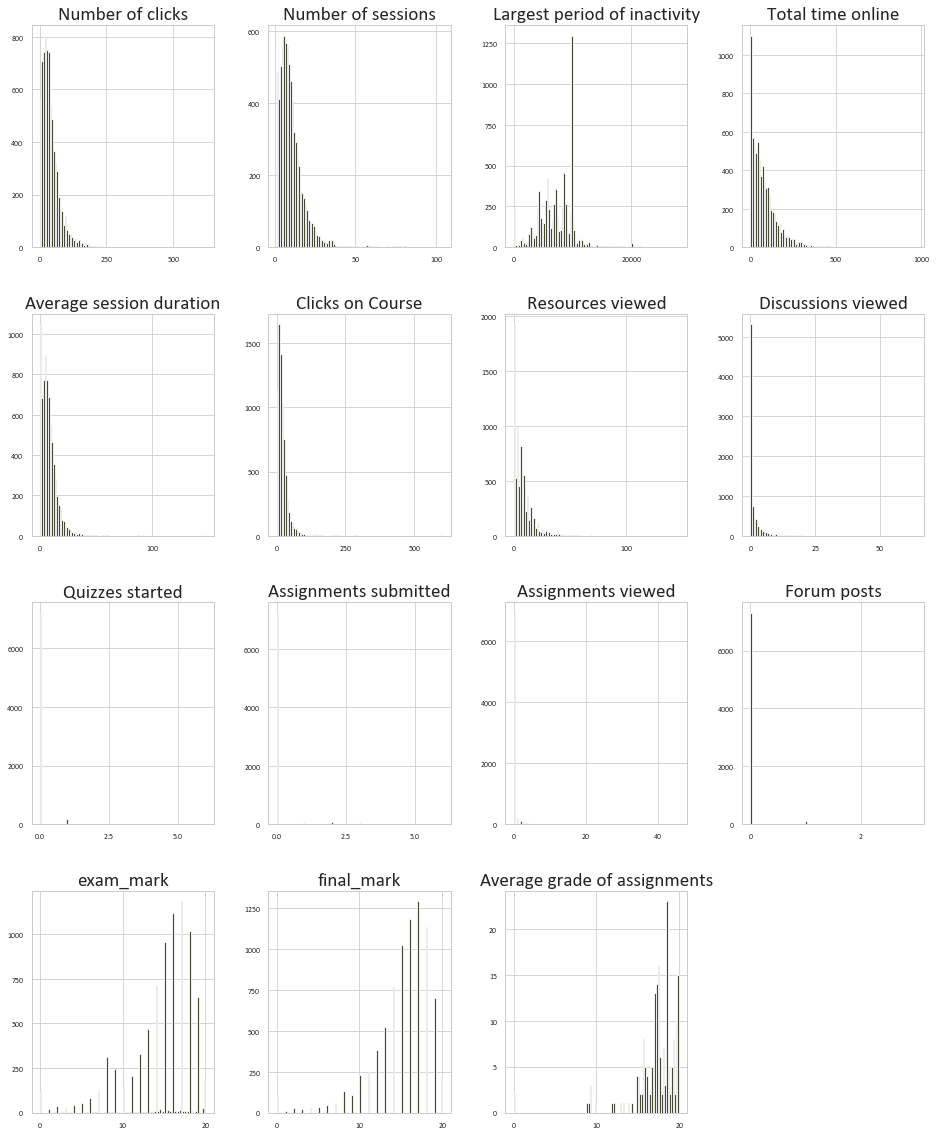

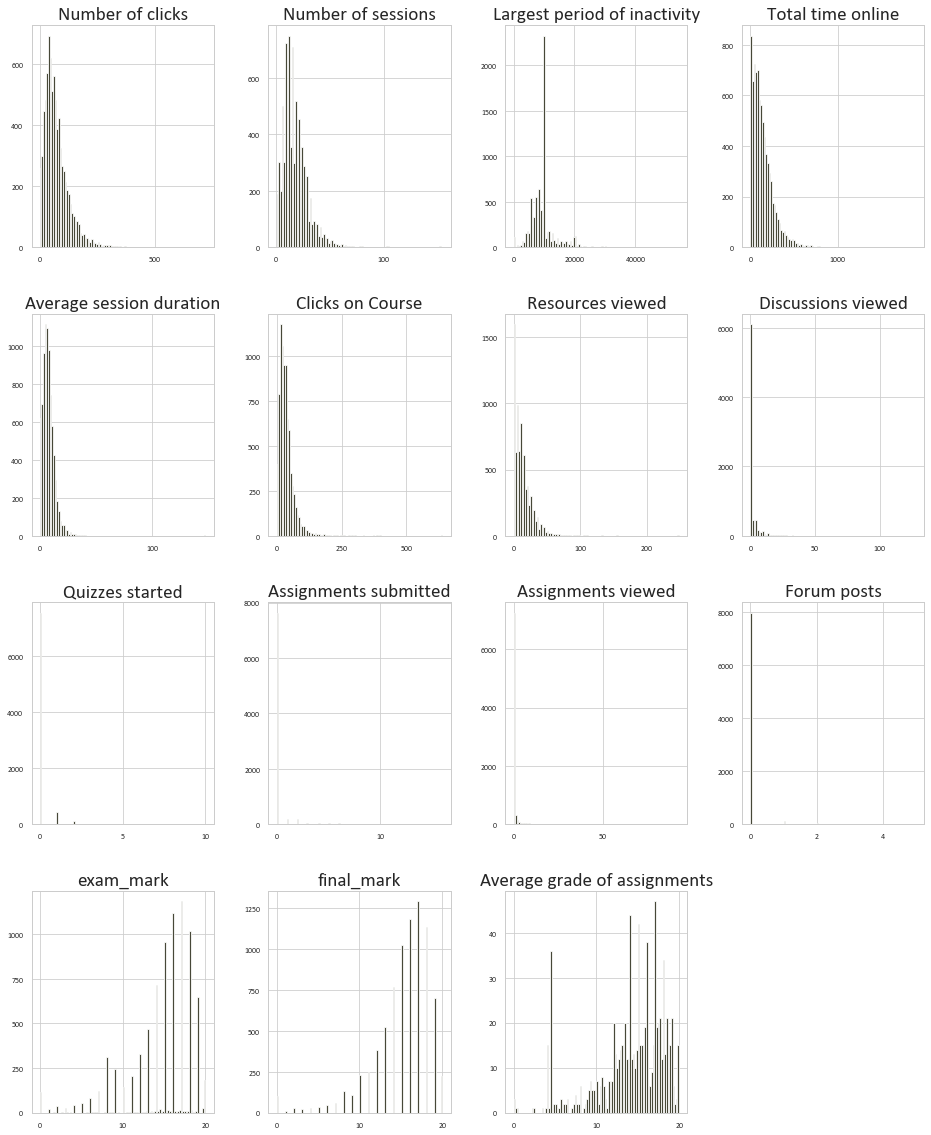

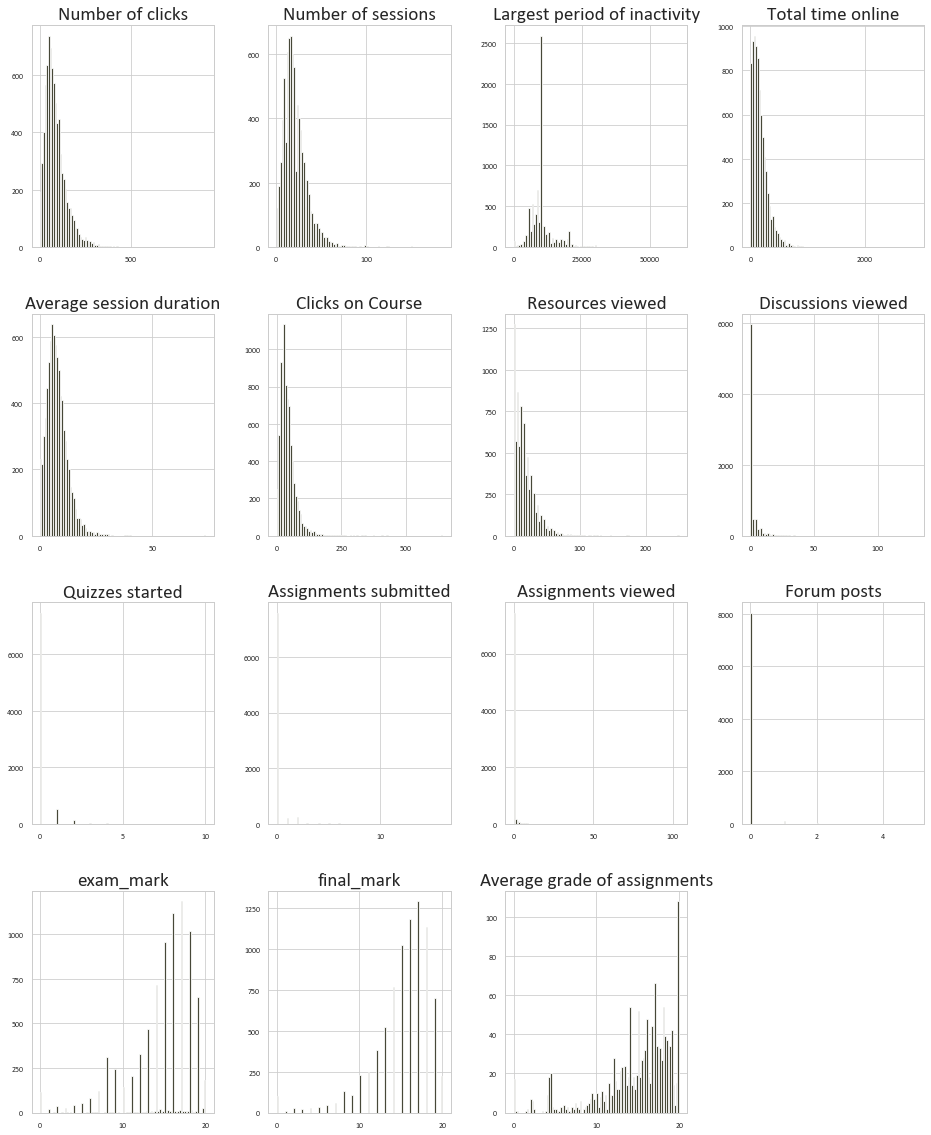

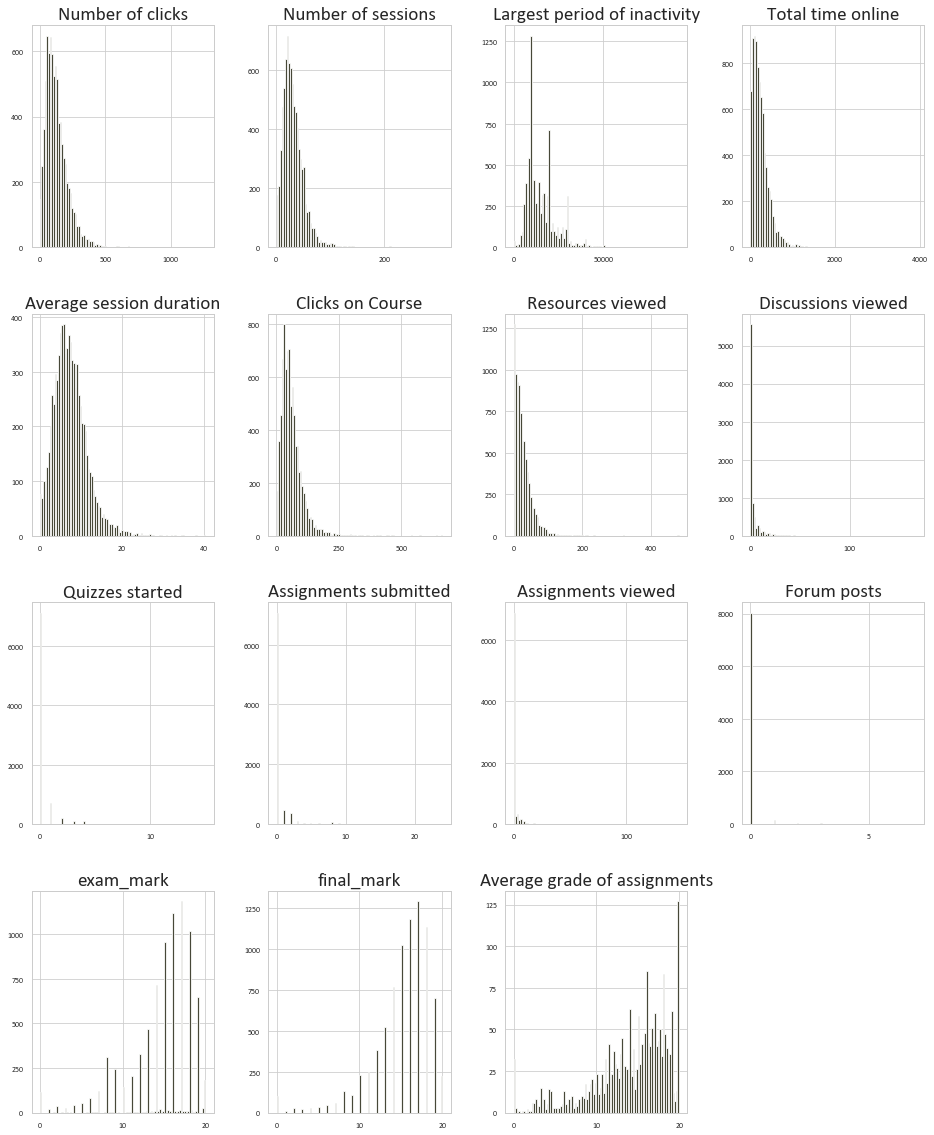

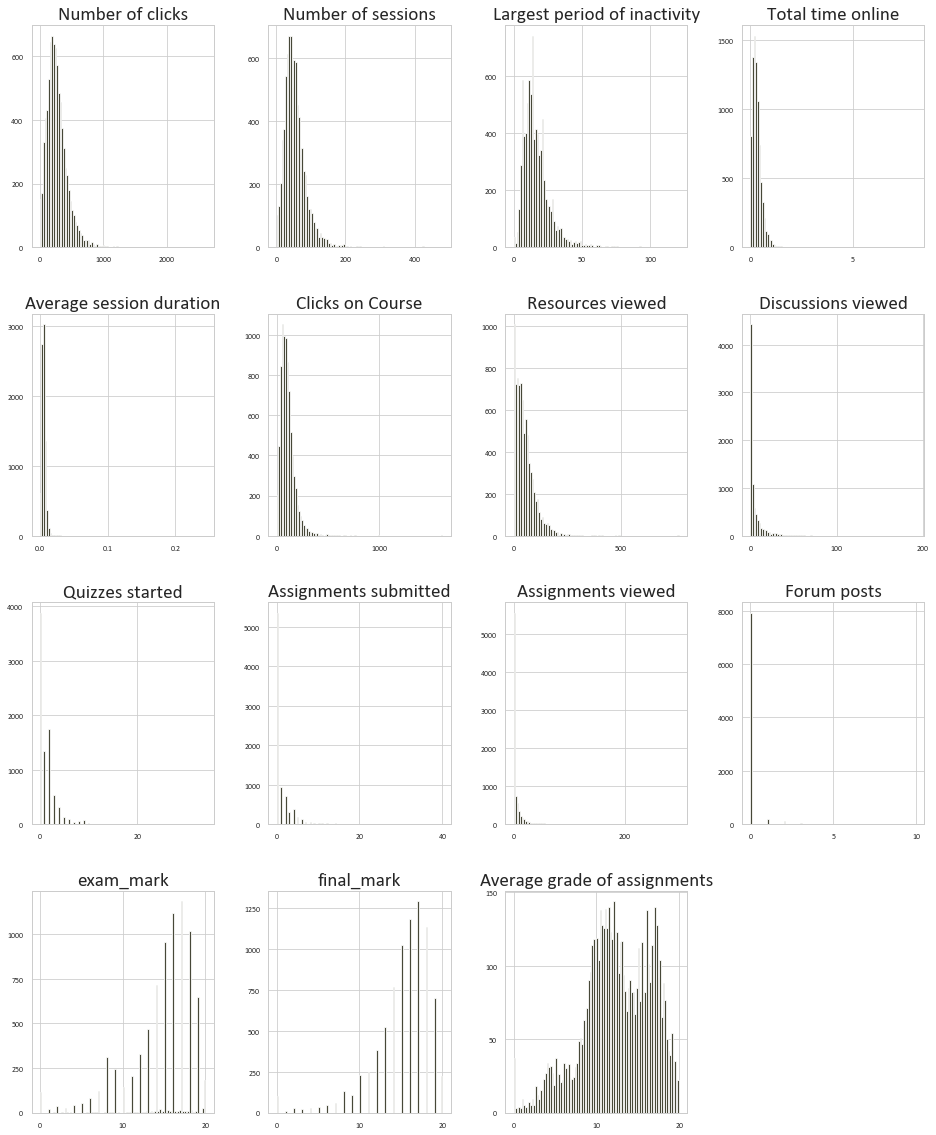

In [8]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)

#Plot the distributions of each feature 
for i in tqdm(course_programs):
    print(i)
    course_programs[i].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8, color = student_color)

#### Converting target:

As stated, we will predict the exam grade as it does not depend direcly from assignment grades.

We will use a double classification problem:

**Problem 1**: Identify students at risk of failure. In the portuguese system, a student passes if the final grade greater or equal to 10. Students who do not meet the threshold fail. When it comes to exams, the difference is not as clear cut. For simplicity, we will consider exam grade to be less or equal to 10 - same with final grade. 

**Problem 2**: Identify high performing students. The classification of high performers is not unanymous. A simple solution would be consider as high performers all students whose grade is greater or equal to a certain threshold (say 17/20). There are issues with this approach however:

    - different teachers have different criteria for grading and their grading decisions. We can look at the top 20% of students in each course as identify them as the high performers. 

In [9]:
#create dicts with proposed gifted student threshold
exam_gifted_threshold = course_programs[i].groupby('course_encoding')['exam_mark'].quantile(.75).to_dict()
final_gifted_threshold = course_programs[i].groupby('course_encoding')['final_mark'].quantile(.75).to_dict()

#create loops for targets

for i in tqdm(course_programs):
    print(i)
    
    #create new columns with the threshold of grades
    course_programs[i]['exam_gifted_threshold'] = course_programs[i]['exam_mark'].map(exam_gifted_threshold)
    course_programs[i]['final_gifted_threshold'] = course_programs[i]['exam_mark'].map(final_gifted_threshold)
    
    #deal with risk of failure
    course_programs[i]['exam_fail'] = np.where(course_programs[i]['exam_mark'] > 11, 0, 1) #at risk in exam
    course_programs[i]['final_fail'] = np.where(course_programs[i]['final_mark'] > 11, 0, 1) #at risk in final grade   
    
    #deal with gifted classification
    course_programs[i]['exam_gifted'] = np.where(course_programs[i]['exam_mark'] > course_programs[i]['exam_gifted_threshold'],
                                                                                                                            1, 0) #gifted students according to exam grade
    course_programs[i]['final_gifted'] = np.where(course_programs[i]['final_mark'] > course_programs[i]['final_gifted_threshold'],
                                                                                                                            1, 0) #gifted students according to final grade
    
    #delete threshold columns, 
    course_programs[i].drop(['exam_gifted_threshold', 'final_gifted_threshold'], axis = 1, inplace = True)

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Date_threshold_25
Date_threshold_33
Date_threshold_50
Date_threshold_100


In [10]:
course_programs['Date_threshold_100'].describe(include = 'all')

,course_encoding,cd_curso,semestre,courseid,userid,Number of clicks,Number of sessions,Largest period of inactivity,Total time online,Average session duration,...,Assignments submitted,Assignments viewed,Forum posts,exam_mark,final_mark,Average grade of assignments,exam_fail,final_fail,exam_gifted,final_gifted
count,8286.0,8286.0,8286,8286.0,8286.0,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,...,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,6289.000000,8286.000000,8286.000000,8286.000000,8286.000000
unique,92.0,6.0,6,83.0,1231.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,69.0,9434.0,S1,200167.0,3178.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,178.0,2671.0,3360,248.0,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,269.956674,54.645909,16.808571,0.314003,0.005764,...,1.165701,5.360367,0.077359,14.623362,15.080859,12.436355,0.171494,0.125996,0.287111,0.303765
std,NaN,NaN,NaN,NaN,NaN,165.971142,35.226072,10.403370,0.252235,0.003750,...,2.600021,13.707109,0.430773,4.002949,3.574331,4.100305,0.376963,0.331864,0.452441,0.459910
min,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,160.000000,33.000000,10.023785,0.154861,0.003977,...,0.000000,0.000000,0.000000,13.000000,14.000000,9.933333,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,244.000000,48.000000,14.134375,0.266667,0.005432,...,0.000000,0.000000,0.000000,16.000000,16.000000,12.410000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,347.000000,69.000000,20.917188,0.413194,0.007144,...,1.000000,5.000000,0.000000,17.000000,17.000000,15.866667,0.000000,0.000000,1.000000,1.000000


In [11]:
# Organizar features
targets = ['exam_mark']

numeric_feat = ['Number of clicks', 'Number of sessions', 'Largest period of inactivity', 'Total time online', 
                'Average session duration', 'Clicks on Course', 'Resources viewed', 'Discussions viewed', 'Quizzes started', 
                'Assignments submitted', 'Assignments viewed', 'Forum posts']

#optional features -> assignment grades
optional_feat =['Average grade of assignments']

#binary_feat = []

#categorical_feat = []

#date = []

In [12]:
#Data Quality Report for Continuous Features

def DescribeContinuousFeatures(Continuous_Features, dataset):
    Continuous_Head = ['Count', 'Missing Values (%)', 'Cardinality', 'Minimum', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Maximum', 'Std. Dev.']
    Continuous_Describe = pd.DataFrame(index=Continuous_Features, columns=Continuous_Head)
    Continuous_Describe.index.name = 'Feature Name'
    columns = dataset[Continuous_Features]

#Total Number of Instances
    Continuous_Describe[Continuous_Head[0]] = columns.count()

#Percentage of instances that has Missing Values (sabendo à partida que nenhuma variável contínua tem missings)
    Continuous_Describe[Continuous_Head[1]] = columns.isnull().sum() * 100 / len(dataset)
    
#Cardinality of each feature (cardinality measures the number of Distinct Values)
    Continuous_Describe[Continuous_Head[2]] = columns.nunique()

#Minimum Value
    Continuous_Describe[Continuous_Head[3]] = columns.min()

#1ST Quartile
    Continuous_Describe[Continuous_Head[4]] = columns.quantile(0.25)

#Mean
    Continuous_Describe[Continuous_Head[5]] = round(columns.mean(), 2)

#Median
    Continuous_Describe[Continuous_Head[6]] = columns.median()

#3rd Quartile
    Continuous_Describe[Continuous_Head[7]] = columns.quantile(0.75)

#Maximum Value
    Continuous_Describe[Continuous_Head[8]] = columns.max()

#Standard Deviation
    Continuous_Describe[Continuous_Head[9]] = round(columns.std(),2)
    
    return Continuous_Describe

DescribeContinuousFeatures(numeric_feat,dataframe)

NameError: name 'dataframe' is not defined

In [ ]:
#hidden ofor faster computation

#perform a very simple pairplot
g = sns.PairGrid(dataframe[numeric_feat], height = 10, corner = True)

#frequency histogram on diagonal
g.map_diag(sns.histplot, color = 'grey', stat = 'frequency', kde = True)

#regplot is a scatter with regression line
g.map_offdiag(sns.regplot, fit_reg=True, x_jitter=.1, color = 'salmon',  marker = 'x')

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

In [ ]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_spearman = dataframe[numeric_feat].corr(method = 'spearman')
cor_heatmap(cor_spearman)

In [ ]:
#Data Quality Report for Categorical Features

def DescribeCategoricalFeatures(Categorical_Features, dataset):
    Categorical_Head = ['Count', 'Missing Values (%)', 'Cardinality', 'Mode', 'Mode frequency', 'Mode (%)',\
                        '2nd Mode', '2nd Mode frequency', '2nd Mode (%)']

    Categorical_Describe = pd.DataFrame(index=Categorical_Features, columns=Categorical_Head)
    Categorical_Describe.index.name = 'Feature Name'
    columns = dataset[Categorical_Features]
    
    #Total Number of Instances
    Categorical_Describe[Categorical_Head[0]] = columns.count()
    missings = []
    for col in columns:
        missings.append(len(dataset[dataset[col]=='?']) * 100/ len(dataset))
    #Percentage of instances that has Missing Values 
    Categorical_Describe[Categorical_Head[1]] = missings
    
    #Cardinality of each feature (cardinality measures the number of Distinct Values)
    Categorical_Describe[Categorical_Head[2]] = columns.nunique()
    
    Categorical_Describe[Categorical_Head[3]] = columns.mode().T
    
    Categorical_Describe[Categorical_Head[4]] = columns.describe().T['freq']
    
    Categorical_Describe[Categorical_Head[5]] = columns.describe().T['freq']/columns.describe().T['count']
    
    snd_modes = []
    snd_modes_freq = []
    for col in columns:
        snd_modes.append(columns[col].value_counts().index[1])
        snd_modes_freq.append(columns[col].value_counts()[1])
        
    Categorical_Describe[Categorical_Head[6]] = snd_modes
    
    Categorical_Describe[Categorical_Head[7]] = snd_modes_freq
    
    Categorical_Describe[Categorical_Head[8]] = Categorical_Describe[Categorical_Head[7]]/columns.describe().T['count']
    
    return Categorical_Describe

DescribeCategoricalFeatures(categorical_feat,dataframe)

In [ ]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="skyblue")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.xticks(rotation='vertical')
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="skyblue")
    plt.xticks(rotation='vertical')
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

In [ ]:
for var in categorical_feat:
    bar_charts_categorical(dataframe, var, 'IsCanceled')

In [ ]:
country_cancel = dataframe['Country'].value_counts().rename("Occurrences").to_frame()
country_cancel['canceled'] = dataframe[dataframe['IsCanceled']==1]['Country'].value_counts()
country_cancel = country_cancel.fillna(0)
country_cancel['%canceled'] = country_cancel['canceled']/country_cancel['Occurrences']

fig = px.choropleth(country_cancel, locations=country_cancel.index,
                    color='%canceled', # lifeExp is a column of gapminder
                    hover_name=country_cancel.index, # column to add to hover information
                    color_continuous_scale=px.colors.diverging.Temps,
                   title='Country % of cancelations')
fig.show()

### Immediate observations

Very low correlations throughout among metric features.
Still need to verify what to do concerning outliers.

## Functions to Call later

In [ ]:
#ENCODERS
def encode_categorical(dataset):
    encoded_df = dataset.copy()

    #months
    months = {'January':1,'February':2,'March':3,'April':4,'May':5,
             'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    encoded_df['ArrivalDateMonth'] = encoded_df['ArrivalDateMonth'].map(months)
    
    #countries
    other_countries = list(filter(lambda w: w not in ['PRT','ITA','GBR','FRA','DEU','ESP'], list(encoded_df['Country'].unique())))
    encoded_df['Country'] = encoded_df['Country'].replace(other_countries,'Other')
    countries = {'PRT':1,'FRA':2,'DEU':3,'GBR':4,'ESP':5,'ITA':6,'Other':7}
    encoded_df['Country'] = encoded_df['Country'].map(countries)
    
    #To one-hot
    list_to_dummify =['Meal','DepositType','CustomerType','MarketSegment']
    
    dummies = pd.get_dummies(encoded_df[list_to_dummify])
    encoded_df = encoded_df.join(dummies)
    encoded_df.drop(columns = list_to_dummify,axis=1,inplace=True)
    
    #ordinal    
    #confirmar agent e company
    enc = OrdinalEncoder()
    to_encode = ["ReservedRoomType","AssignedRoomType",'DistributionChannel']
    encoded_df[to_encode] = enc.fit_transform(encoded_df[to_encode])
        
        
        
        
    return encoded_df

In [ ]:
def feature_selection_table(dataset):

    feature_df = dataset.copy()

    X = feature_df.drop(['IsCanceled'],axis=1)
    y = feature_df['IsCanceled']
    num_feats=len(X.columns)
    X_norm = MinMaxScaler().fit_transform(X)

    #RFE
    rfe_selector = RFE(estimator=DecisionTreeClassifier(), step=2)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()

    #RFECV
    rfecv_selector = RFECV(estimator=DecisionTreeClassifier(), step=3, cv=5, scoring='f1_weighted')
    rfecv_selector = rfecv_selector.fit(X_norm, y)
    rfecv_support = rfecv_selector.support_
    rfecv_feature = X.loc[:,rfecv_support].columns.tolist()

    #Logistic regression
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

    #RandomForest 
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


    #LGBMClassifier
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

    #Lasso
    reg = LassoCV(random_state=123) 
    reg.fit(X=X,y=y)
    lasso_coef = pd.Series(reg.coef_,index = X.columns)

    #Ridge
    ridge = RidgeCV()
    ridge.fit(X=X,y=y)
    coef_ridge = pd.Series(ridge.coef_,index = X.columns)

    #Elastic 
    elast = ElasticNetCV(cv=5, random_state=123)
    elast.fit(X, y)
    elast_coef = pd.Series(elast.coef_,index = X.columns)

    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':X.columns, 'RFE':rfe_support,'RFECV':rfecv_support, 'Logistics':embeded_lr_support,
                                        'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'Lasso':lasso_coef != 0, 'Ridge':coef_ridge != 0, 'Elastic':elast_coef != 0})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total'] , ascending=False)
    feature_selection_df.set_index('Feature',inplace=True)
    feature_selection_df
    
    return feature_df,feature_selection_df

In [ ]:
def normalize(dataset,scaler):
    
    if scaler == 'MinMax':
        pt = MinMaxScaler()
    elif scaler == 'Standard':
        pt = StandardScaler()
    elif scaler == 'Robust':
        pt = RobustScaler()
    elif scaler == 'Quantile':
        pt = QuantileTransformer()
    else:
        pt = PowerTransformer(method='yeo-johnson')
    
    data = pt.fit_transform(dataset)
    
    # convert the array back to a dataframe
    normalized_df = pd.DataFrame(data,columns=dataset.columns)
    return normalized_df

# Starting data preparation:


## Start by Calling the Funtions

In [ ]:
#Dropping non relevant features

data_prep_df = dataframe.drop(columns =['ReservationStatus','ReservationStatusDate','ArrivalDateYear'])
#data_prep_df['Agent'] = data_prep_df['Agent'].replace(NULL,0)
data_prep_df['Company'] = data_prep_df['Company'].str.replace('NULL','0').astype(int)
data_prep_df['Agent'] = data_prep_df['Agent'].str.replace('NULL','0').astype(int)

In [ ]:
X = data_prep_df.drop(['IsCanceled'],axis=1)
y = data_prep_df['IsCanceled']

In [ ]:
encoded_df = encode_categorical(data_prep_df)

In [ ]:
#Feature Selection Table cited in report

feature_df,feature_selection_df = feature_selection_table(encoded_df)
feature_selection_df

In [ ]:
final_feature_dataset = feature_df[feature_selection_df.loc[feature_selection_df['Total'] >3].index.tolist()]
#general normalization
normalized_dataset = normalize(final_feature_dataset,'Quantile')

In [ ]:
X = normalized_dataset

In [ ]:
X

# MODEL TESTING & SELECTION

We will make a split between between train and test. As we will use cross validation (repeated_Stratified_k_fold)



In [ ]:
#train_test_split to get 20% of data as test

X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                  y,
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y)

In [ ]:
#run desired model
def run_model(model_name, X, y):
    
    ###STANDALONE MODELS
    if model_name == 'KNN':
        #Manhattan distance, which should work better for high dimensional datasets
        #weights to attribute higher weight to closer neighbors; seems to improve score highly
        model = KNeighborsClassifier(n_neighbors=10, p = 1, weights='distance').fit(X, y) #
    if model_name == 'LR':
        model = LogisticRegression().fit(X, y) #
    if model_name == 'NB': 
        model = GaussianNB().fit(X, y)
    if model_name == 'BNB': #
        model = BernoulliNB().fit(X, y)
    if model_name == 'MNB': #
        model = MultinomialNB().fit(X, y)
    if model_name == 'NN': #
        model = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000).fit(X, y)
    if model_name == 'DT':
        model = DecisionTreeClassifier(criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y) #max_features=6,
    if model_name == 'SVM': #
        model = svm.SVC(C=0.05, degree=2, gamma='scale', kernel='rbf').fit(X, y)
    
    ###ENSEMBLES
    if model_name == 'RF':
        model = RandomForestClassifier(max_depth = 11, random_state = 5, n_estimators=500, min_samples_leaf = 3).fit(X, y) #max_features=6, #max_depth é super imp para reduzir overfitting! #min_samples_lead highly reduces overfitting!
    if model_name == 'Bagg_NN':
        model = BaggingClassifier(base_estimator = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000), n_estimators = 5, random_state = 5).fit(X, y)
    if model_name == 'AdaBoost':
        model = AdaBoostClassifier(n_estimators = 95, learning_rate = 0.8, random_state = 5).fit(X, y) #importante que GSearchCV em DT maximizado!
    if model_name == 'GBoost':
        model = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15).fit(X, y)
    if model_name == 'ExtraTree':
        model = ExtraTreesClassifier(n_estimators=175, criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y)
    return model

In [ ]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'GBoost':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix


In [ ]:
###STANDALONE MODELS:

#runs each Repeated (10) 10-fold Cross-Validation in all tested models by calling function avg_score and prints resutls with multiple metrics for each

method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_KNN = avg_score(method_cv, X_train_val, y_train_val, 'KNN')
results_LR = avg_score(method_cv, X_train_val, y_train_val, 'LR')
results_NB = avg_score(method_cv, X_train_val, y_train_val, 'NB')
results_BNB = avg_score(method_cv, X_train_val, y_train_val, 'BNB')
results_MNB = avg_score(method_cv, X_train_val, y_train_val, 'MNB')
results_NN = avg_score(method_cv, X_train_val, y_train_val, 'NN')
results_DT = avg_score(method_cv, X_train_val, y_train_val, 'DT')
resultsSVM = avg_score(method_cv, X_train_val, y_train_val, 'SVM')


In [ ]:
results_models = [results_KNN, results_LR, results_NB, results_BNB, results_MNB, results_NN, results_DT, resultsSVM]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM'])

df

In [ ]:
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test):
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (20, 10))

    #sets style of the plot to increase readibility
    sns.set_style(style="whitegrid")

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6

    #makes the plot
    plt.bar(pos_train, f1micro_train, color='dodgerblue', width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color='steelblue', width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color='skyblue', width=barwidth, edgecolor='white', label='Test')

    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')

    #personalizes yticks to inrease readibility of data in the plot
    ax.set_yticks(np.arange(0, 1, 0.1))

    #ads title to the plot
    plt.title('10-fold Repeated Cross-Validation Results', fontsize = 14)

    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)

    #shows plot
    plt.show()

In [ ]:
models = ['KNN', 'LR', 'NB', 'BNB', 'MNB', 'NN', 'DT', 'SVM']
plt_bar(models, f1micro_train, f1micro_val, f1micro_test)

In [ ]:
def plot_roc_pr(models, X, y):  
    sns.set_style(style="whitegrid")
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC Curve Test')
    plt.legend(loc="lower right", frameon=False)
    plt.show()

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)')
    plt.ylabel('Precision (True Positive Rate)')
    plt.title('Precision-Recall Curve Test')
    plt.legend(loc="lower left", frameon=False)
    plt.show()

In [ ]:
plt.figure()

# Add models to list of models to incorporte in ROC curve
models = [{'label': 'KNN', 'model': run_model('KNN', X_train_val, y_train_val),},
          {'label': 'LR', 'model': run_model('LR', X_train_val, y_train_val),},
          {'label': 'NB','model': run_model('NB', X_train_val, y_train_val),},
          {'label': 'BNB', 'model': run_model('BNB', X_train_val, y_train_val),},
          {'label': 'MNB', 'model': run_model('MNB', X_train_val, y_train_val),},
          {'label': 'NN', 'model': run_model('NN', X_train_val, y_train_val),},
          {'label': 'DT', 'model': run_model('DT', X_train_val, y_train_val),},] 
            #SVM not included coz there's no probs!
    
plot_roc_pr(models, X_test, y_test)

Given the fact that Decision Trees were a standalone model that yielded the best results (along with Neural Networks and Logistic Regression), we decided to try out a few ensemble methods that have Decision Trees as base learners:

In [ ]:
method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 15)

results_Bag_NN = avg_score(method_cv, X_train_val, y_train_val, 'Bagg_NN')
results_RF = avg_score(method_cv, X_train_val, y_train_val, 'RF')
results_AdaBoost = avg_score(method_cv, X_train_val, y_train_val, 'AdaBoost')
results_GBoost = avg_score(method_cv, X_train_val, y_train_val, 'GBoost')
results_Xtra = avg_score(method_cv, X_train_val, y_train_val, 'ExtraTree')

In [ ]:
results_models = [results_Bag_NN, results_RF, results_AdaBoost, results_GBoost, results_Xtra]

f1micro_train = []
f1micro_val = []
f1micro_test = []

precision_train = []
precision_val = []
precision_test = []

recall_train = []
recall_val = []
recall_test = []

times = []

#organizes data for futher plotting
for i, model in enumerate(results_models):
    
    f1micro_train.append(results_models[i][1])
    f1micro_val.append(results_models[i][2])
    f1micro_test.append(results_models[i][3])
    
    precision_train.append(results_models[i][4])
    precision_val.append(results_models[i][5])
    precision_test.append(results_models[i][6])
    
    recall_train.append(results_models[i][7])
    recall_val.append(results_models[i][8])
    recall_test.append(results_models[i][9])
    
    times.append(results_models[i][0])
    
results = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

df = pd.DataFrame(results, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['Bagg_NN', 'RF', 'AdaBoost', 'GBoost', 'ExtraTree'])

print('Averaged Confusion Matrix for XtraTree:\n', results_models[4][10])

df 

## Comparative ROC and Precision Recall Plot of Best Performing Models

In [ ]:
# Add models to list of models to incorporte in ROC curve
models = [{'label': 'DT', 'model': run_model('DT', X_train_val, y_train_val),},
          {'label': 'RF', 'model': run_model('RF', X_train_val, y_train_val),},
          {'label': 'GBoost', 'model': run_model('GBoost', X_train_val, y_train_val),},
          {'label': 'ExtraTree', 'model': run_model('ExtraTree', X_train_val, y_train_val),}]


plot_roc_pr(models, X_test, y_test)

We finish by understanding that ExtraTrees Classifiers looks to be most suitable model. In the next Notebook, we will look to optimize our ExtraTrees Classification.